# MAPD-B: Pyspark implementation of kmeans || - 2D testing
### Antonio Feltrin (2097126), Giosuè Sardo Infirri (2094560), Simone Toso (2095484)

In this project we will implement the ```kmeans||```, ```kmeans++``` and ```kmeans``` algorithms in PySpark as described in Bahmani's paper. We will use the ```kddCup99``` dataset as a testing ground.

The overall code will follow the procedure presented in the paper:
 - ```kmeans||```:  algorithm for the selection of possible initial centroids. It heavily relies on oversampling and will therefore pick on average more candidate centers than desired.
 - ```kmeans++```: used to select $k$ initial centroids out of the candidates proposed by ```kmeans||```
 - ```kmeans```: final algorithm for clusterization starting from the centroids obtained with ```kmeans++```.


# Spark context initialization

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("spark://10.67.22.124:7077")\
    .appName("paintball")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

23/09/18 17:58:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
spark

In [3]:
# Create a spark context
sc = spark.sparkContext
sc

<SparkContext master=spark://10.67.22.124:7077 appName=PySparkShell>

In [4]:
sc.setLogLevel("ERROR")

In [5]:
#Import libraries
import numpy as np
import pandas as pd
import random
#import sklearn.datasets 
import time
import matplotlib.pyplot as plt

from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import col
from pyspark.sql.functions import mean
from pyspark.sql.functions import stddev
from pyspark.sql.functions import rand
from pyspark.sql.functions import lit
from pyspark.sql.functions import least
from pyspark.sql import Row
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import StringType
from pyspark.sql.functions import row_number
from pyspark.sql import Window
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import when
from pyspark.sql.functions import udf, array
from pyspark.sql.types import IntegerType, FloatType

from operator import add
from functools import reduce

In [6]:
time0 = time.time()

## Hyperparameters
Here we set the various hyperparameters. 

- ```k``` is the number of centroids we want to obtain
- ```len_df``` is the number of rows considered out of the whole dataset. The maximum value we consider is 494 021, corresponding to 10% of the entire dataset (note that the ```fetch_kddcup99()``` command takes automatically 10% of the dataset if not specified otherwise).
- ```G``` is used to evaluate the oversampling factor ```l```. In particular we will have $l = G\cdot \frac{k}{\log \phi}$, where $\phi$ is the initial cost. We expect that, after the implementation of ```kmeans||```, we will have around $k\cdot G$ possible centroids. The implementation of ```kmeans++``` will select $k$ centroids out of these possible candidates.

In [7]:
# Hyperparameters
k = 6
G = 3 
len_df = 300

np.random.seed(1234)

In [8]:
all_points = pd.DataFrame(columns = ['x','y'])
color_points = pd.DataFrame(columns = ['x','y','color'])

The category 1 has the two gaussians: -4 +- 0.1915194503788923 and 5 +- 0.8178384411165694
The category 2 has the two gaussians: 7 +- 0.6848785772557386 and 4 +- 0.984369011651947
The category 3 has the two gaussians: 8 +- 0.5610165214378405 and 1 +- 0.8765647930363808
The category 4 has the two gaussians: -1 +- 0.7671870920361179 and -2 +- 0.47623073157989426
The category 5 has the two gaussians: 0 +- 0.8149882016792263 and 3 +- 0.48642875601248003
The category 6 has the two gaussians: 6 +- 0.5830050050815052 and -9 +- 0.2165434304362266


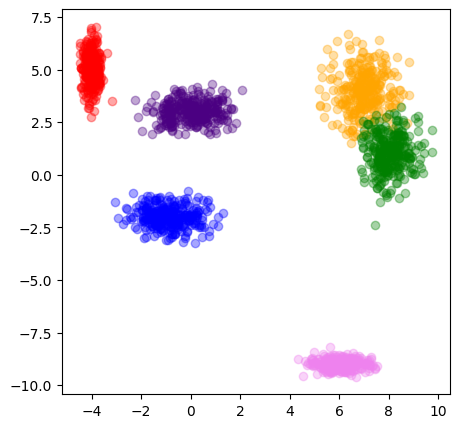

In [9]:
category = k # Number of cathegories shown in the plot
points = len_df #300 # Resolution of the plotted graphics

fig = plt.figure(figsize=(5, 5))
n=0

mycols = ['red','orange','green','blue','indigo','violet']
while n < category:
    std_x, mean_x = np.random.random(), np.random.randint(-10, 10)
    std_y, mean_y = np.random.random(), np.random.randint(-10, 10)

    gaussian_x = np.random.normal(mean_x, std_x, points)
    gaussian_y = np.random.normal(mean_y, std_y, points)
    
    data_xy = pd.DataFrame({'x':gaussian_x,'y':gaussian_y})
    data_rgb = pd.DataFrame({'x':gaussian_x,'y':gaussian_y,'color':mycols[n]})
    all_points = pd.concat([all_points,data_xy])
    color_points = pd.concat([color_points,data_rgb])
    
    plt.scatter(gaussian_x, gaussian_y, color=mycols[n], alpha=0.35)
    print('The category', n+1, 'has the two gaussians:', mean_x, '+-', std_x, 'and', mean_y, '+-', std_y)
    n += 1

plt.show()

In [10]:
mycols[0]

'red'

In [11]:
color_points.count()

x        1800
y        1800
color    1800
dtype: int64

In [12]:
X = all_points
X.count()

x    1800
y    1800
dtype: int64

In [13]:
n_cols = len(X.iloc[0])

In [14]:
# Create the spark dataframe with a smaller chunk of data (just to work easily)
spark_X = spark.createDataFrame(X)
spark_X = spark_X.persist()

# Import data and create a Spark dataframe

We now import the dataset and select randomly ```len_df``` rows. This will be the dataframe we will work on.

In [15]:
spark_X = spark_X.persist()

In [16]:
# Define a function that is able to extract a single row from the dataframe
def getrows(df, rownums=None):
    return df.rdd.zipWithIndex().filter(lambda x: x[1] in rownums).map(lambda x: x[0])   

In [17]:
# Delete the non-numerical values
col_type = np.array(spark_X.dtypes)
types = col_type[:,1] 
colnames = col_type[:,0]
clean_X = spark_X.select([col(colnames[i]) for i in range(len(colnames)) if not types[i] == 'binary'])

In [18]:
# Define the number of rows and columns in the dataframe
n_rows = len_df
n_cols = len(getrows(clean_X, rownums=[0]).collect()[0])

In [19]:
n_cols

2

We print the two schemas to check that the non-numerical variables were removed correctly

In [20]:
spark_X.printSchema()

root
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)



In [21]:
clean_X.printSchema()

root
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)



# kmeans|| - step 0: Useful functions

In [22]:
# Define the function for the squared distance between the cluster centers and the pandas dataframe (no more used)
def distance(xrow, centers, num_cols=n_cols):
    x = np.array(xrow)[:num_cols]
    the_ds = np.zeros(len(centers))
    
    for c in range(len(centers)):
        c_array = np.array(centers[c])[:num_cols]
        dist2 = np.linalg.norm(x - c_array)**2
        the_ds[c] = dist2
        
    return np.min(the_ds)

# Euclidean distance between two rows (limited to the first n_cols)
def euclid(xrow0, xrow1, num_cols = n_cols):
    return np.linalg.norm( np.array(xrow0[0:num_cols]) - np.array(xrow1[0:num_cols]) )

# Formula to evaluate the oversamping factor with the pre-factor G
def evaluate_l(log_phi, k, G):
    return G * k/log_phi # G = over-oversampling factor

# Function to select a row based on its probability
def select_row(x):
    if x > np.random.uniform(low = 0, high = 1):
        return True
    else:
        return False



# Kmeans|| - step 1. First sample and initial cost
To start things off, we randomly choose the first centroid and evaluate the cost function.

In [23]:
# Choose the first sample randomly: select the random row
random_n = [np.random.randint(0, n_rows)]
random_sample = getrows(clean_X, random_n).collect()

In [24]:
# Names of the dataset's columns.
colnames = list(clean_X.dtypes[i][0] for i in range(len(clean_X.dtypes)))

In [25]:
# Add the colunm to keep the minimum distance between each point and the closest center
clean_X = (clean_X.select('*')
           .withColumn('minimum_cost', sum((col(colname)-random_sample[0][colname])**2 for colname in colnames)))

In [26]:
# Initial cost
initial_cost = np.log(clean_X.agg({"minimum_cost": "sum"}).collect()[0][0])
initial_cost

12.207400337340554

In [27]:
# Add the "minimum_cost" column to the center (with value 0), to avoid having different lengths in the final center list.
temp = random_sample[0].asDict()
temp["minimum_cost"] = 0.
random_sample[0] = Row(**temp)

We wanted to avoid having the centers scattered across multiple nodes, so we chose to broadcast the list of selected centers. If we didn't do it, each computation of euclidean distance would have been very heavy on the network communication.

In [28]:
# Broadcasting the row over the workers
bCent = sc.broadcast(random_sample)

# kmeans|| - step 3: Loop implementation
We now evaluate the number of iterations we want to cycle through and implement the for loop. In each iteration we will independently select centers based on their distance from those already selected.

In the loop, we evaluate the distance from the newly selected centers only and compare it to the previous minimum distance. This way, we avoid computing multiple times the distance from centers which we already know are not the closest ones from a given row.

In [29]:
# n_iterations = log(phi)
n_iter = int(initial_cost)
n_iter

12

In [30]:
#Initialize cost 
phi_iter = initial_cost

#Evaluate oversampling factor
l = evaluate_l(phi_iter, k, G)
l

1.4745154170901382

In [31]:
i = 0 # count iterations
last_centers = 1 # how many centers were selected in the previous iteration. Initialized to 1

while i < n_iter: 

        '''
        Nel ciclo for:
            - Evaluate for each row l * d()^2 / phi
            - Sample with that probability
            - Broadcast centers to nodes
            - Evaluate new cost

        '''

        # Evaluate the probability and select the new center rows
        mod_phi = l/np.exp(phi_iter) #Normalization factor to obtain selection probability 
        new_rows = clean_X.select('*').withColumn('random_number', rand(seed=int(time.time())))\
                          .filter(col('random_number') < col('minimum_cost')*mod_phi).drop('random_number').collect()
        
        # Update the broadcast with newest at the beginning
        old_centers = bCent.value
        bCent.destroy()
        bCent = sc.broadcast(new_rows + old_centers)
    
        # Update the minimum distance
        if len(new_rows) == 1:
            clean_X = clean_X.select('*').\
                      withColumn('minimum_cost', least('minimum_cost', reduce(add, [(col(colname)-bCent.value[0][colname])**2 for colname in colnames]))).cache()

        elif len(new_rows) > 1:
            clean_X = clean_X.select('*').withColumn('dummy', least(*[reduce(add, [(col(colname)-bCent.value[center][colname])**2 for colname in colnames]) for center in range(len(new_rows))] )).\
                      withColumn('minimum_cost', least('minimum_cost', 'dummy')).\
                      drop('dummy').cache()

        last_centers = len(bCent.value)

        # Evaluate new cost
        phi_iter = np.log(clean_X.agg({"minimum_cost": "sum"}).collect()[0][0])

        i += 1

        print("\n at iteration", i ,", #values: ",len(bCent.value), " \n")


 at iteration 1 , #values:  3  


 at iteration 2 , #values:  3  


 at iteration 3 , #values:  5  


 at iteration 4 , #values:  5  


 at iteration 5 , #values:  6  


 at iteration 6 , #values:  9  


 at iteration 7 , #values:  10  


 at iteration 8 , #values:  11  


 at iteration 9 , #values:  11  


 at iteration 10 , #values:  11  


 at iteration 11 , #values:  16  


 at iteration 12 , #values:  16  



In [32]:
print("Centers found: ", len(bCent.value))

Centers found:  16


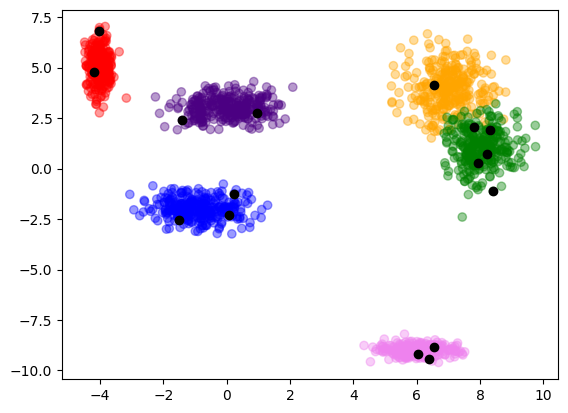

In [33]:
plt.scatter(color_points['x'],color_points['y'],color=color_points['color'],alpha=0.4)

for i in range(len(bCent.value)):
    plt.scatter(bCent.value[i][0],bCent.value[i][1],color='black')

# kmeans++ - step 0: Useful functions
We define a few functions which will be useful in the following code. They allow us, given a certain ```Row```, to find the closest center and the minimum distance.

In [34]:
# Find the closest center to a certain row
def find_min_euclid(xrow, broadC):
    distances = []
    for i in range(len(broadC.value)):
        distances.append(euclid(xrow, broadC.value[i]))
    return distances.index(min(distances))

# Find the minimum distance between row and centers
def min_euclid(xrow, broadC):
    distances = []
    for i in range(len(broadC.value)):
        distances.append(euclid(xrow, broadC.value[i])**2)
    return min(distances).item()

In [35]:
#Create a dataframe with the candidate centers
dfCent = spark.createDataFrame(bCent.value) 

In [36]:
dfCent.rdd.getNumPartitions()

12

# kmeans++ - step1: Evaluate weights

The weight $w$ of a center is the number of points in ```clean_X``` which are closest to it than to any other center

In [37]:
over_sampled_centers = dfCent.count()

In [38]:
wx = clean_X.rdd.map(lambda row: (find_min_euclid(row,bCent), 1)).\
        reduceByKey(lambda x,y: x+y).\
        takeOrdered(over_sampled_centers)

### Technical note

<em>Now we could have a problem. During the row sampling in the `kmeans||` process, it could happen that two identical rows (with indeces $i$ and $j$, $i<j$) are selected at the same loop iteration. This happens quite often if we have $G\gg1$. This results in one of the two centroids not appearing in ```wx```: all rows closest to $j$ are redirected towards $i$, even $j$ itself. So wx has a vacancy: the sequence goes 1,2,3, ..., $i$, ..., $j-1$, $j+1$, ...  . In order to solve this issue, we manually add missing entries and set their value to 0. This implies that the "twin" center has zero probability to be selected. All of this kerfuffle is just due to prevent a size error in the `rows_prob@wx` product, some cells below this line.<em/>

In [39]:
np.array(wx)[:,0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [40]:
counter = 0

while counter < len(wx):
    if wx[int(counter)][0] == counter:
        counter += 1
    else: 
        wx.insert(int(counter),(counter,0))
        counter += 1

In [41]:
#Take the weights and cast to float
wx = (np.array(wx)[:,1]).astype(float)

In [42]:
#Normalize weights
wx /= np.sum(wx)

# kmeans++ - step 2: Loop

In [43]:
# Draw 1 random center
first_index = np.random.choice(a=range(wx.shape[0]), size=1, p=wx) 
first_index

array([15])

In [44]:
first_center = getrows(dfCent, first_index).collect()

In [45]:
# Adds the first center to the ultimate center broadcast
bCent_ultimate = sc.broadcast(first_center)
bCent_ultimate.value

[Row(x=-4.1859911690197436, y=4.796426156471124, minimum_cost=0.0)]

In [46]:
# Define the total distance from other centers (minimum cost) over the chosen center
dfCent = (dfCent.select('*')
         .withColumn('minimum_cost', sum((col(colname)-first_center[0][colname])**2 for colname in colnames)))

In [47]:
ultimate_sample_n = len(bCent_ultimate.value)

while ultimate_sample_n < k: #n_iter or len(bCent.value) < k:

    # Evaluate the probability and select the new rows
    rows_prob = np.array(dfCent.rdd\
                .map(lambda row: distance(row,bCent_ultimate.value)).collect())
    
    # Sample new weighted random center
    another_index = np.random.choice(a=range(wx.shape[0]), size=1, p = rows_prob*wx/(rows_prob@wx) ) 
    another_center = getrows(dfCent, another_index).collect()
    
    # Update the broadcast
    old_centers = bCent_ultimate.value
    bCent_ultimate.destroy()    
    bCent_ultimate = sc.broadcast(another_center + old_centers)
    
    ultimate_sample_n = len(bCent_ultimate.value)
    print("i: ",ultimate_sample_n)
    

i:  2
i:  3
i:  4
i:  5
i:  6


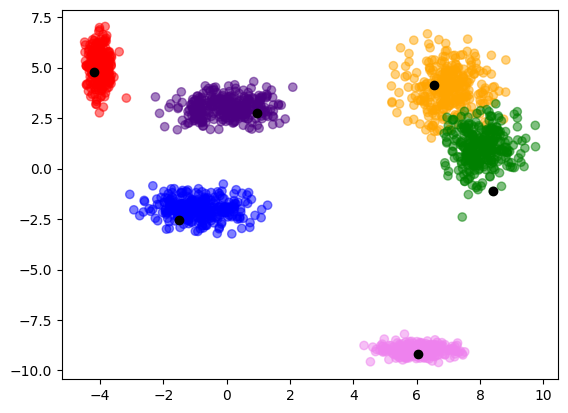

In [48]:
plt.scatter(color_points['x'],color_points['y'],color=color_points['color'],alpha=0.5)

for i in range(len(bCent_ultimate.value)):
    plt.scatter(bCent_ultimate.value[i][0],bCent_ultimate.value[i][1],color='black')

# k means
Finally, we implement ```kmeans``` on our dataset with the initial centroids obtained thus far. We stop when the relative variation of the cost function is smaller than a given threshold $\epsilon$. In this notebook, which serves as a demonstration, we keep $\epsilon = 10^{-4}$. In the benchmarks, however, we will set $\epsilon = 10^{-3}$, so as to avoid long computing times. 

In [49]:
clean_X = clean_X.persist()

In [50]:
#Evaluate the initial value of the cost function
min_cost_udf = udf(lambda row: min_euclid(row, bCent_ultimate), FloatType())
clean_X = clean_X.withColumn("minimum_cost",min_cost_udf(array([col for col in colnames]))).persist()
phi0 = clean_X.agg({"minimum_cost": "sum"}).collect()[0][0]

In [51]:
n = 0
phi1 = phi0
still_different = True
eps = 1e-3

while still_different:

    # Create the weights and switch to indexed dataframe
    find_closest_udf = udf(lambda row: find_min_euclid(row, bCent_ultimate), IntegerType())
    final_df = clean_X.withColumn("closest", find_closest_udf(array([col for col in colnames]))).persist()

    # Update new centers:
    new_centers = final_df.groupBy('closest').agg(*[mean(c).alias(c) for c in colnames]).drop('closest').collect()
    #bCent_ultimate.destroy()
    bCent_ultimate = sc.broadcast(new_centers)

    final_df.unpersist()
    
    # Update the minimum cost function
    min_cost_udf = udf(lambda row: min_euclid(row, bCent_ultimate), FloatType())
    clean_X = clean_X.withColumn("minimum_cost",min_cost_udf(array([col for col in colnames]))).persist()

    # Evaluate new cost
    phi1 = clean_X.agg({"minimum_cost": "sum"}).collect()[0][0]
    print('Relative cost variation:', abs(phi1 - phi0)/phi0)
    if abs(phi1 - phi0)/phi0 < eps:
        still_different = False
    else:
        phi0 = phi1

    n += 1

    #Persist to avoid stack overflow
    clean_X = clean_X.persist()

print('It took', n, 'iterations to converge')

Relative cost variation: 0.5000228756526989
Relative cost variation: 0.039024694289475366
Relative cost variation: 0.004473989936247192
Relative cost variation: 0.0001662438067909029
It took 4 iterations to converge


# Plot results
We plot the final centers, projecting on two variables.

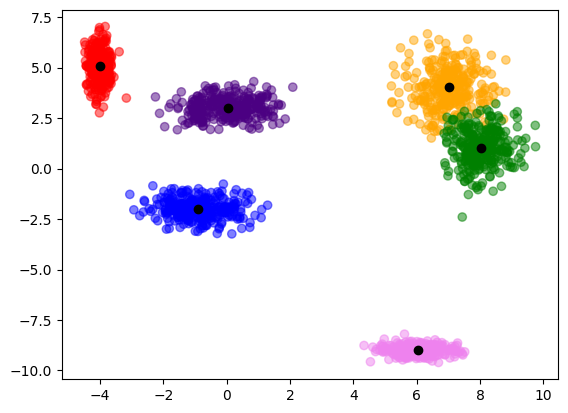

In [52]:
plt.scatter(color_points['x'],color_points['y'],color=color_points['color'],alpha=0.5)

for i in range(len(bCent_ultimate.value)):
    plt.scatter(bCent_ultimate.value[i][0],bCent_ultimate.value[i][1],color='black')

In [53]:
print('final time', time.time() - time0)

final time 21.212915897369385


## Stop worker and master

In [54]:
sc.stop()
spark.stop()